# Interpretable Modelling of Credit Risk

As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

In [2]:
import pandas as pd

# loading data
url = "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/PAKDD%202010/PAKDD2010_Modeling_Data.txt"
df = pd.read_csv(url, header=None, delimiter="\t", encoding="latin1")
df.columns = [
    "ID_CLIENT",
    "CLERK_TYPE",
    "PAYMENT_DAY",
    "APPLICATION_SUBMISSION_TYPE",
    "QUANT_ADDITIONAL_CARDS",
    "POSTAL_ADDRESS_TYPE",
    "SEX",
    "MARITAL_STATUS",
    "QUANT_DEPENDANTS",
    "EDUCATION_LEVEL1",
    "STATE_OF_BIRTH",
    "CITY_OF_BIRTH",
    "NACIONALITY",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "FLAG_RESIDENCIAL_PHONE",
    "RESIDENCIAL_PHONE_AREA_CODE",
    "RESIDENCE_TYPE",
    "MONTHS_IN_RESIDENCE",
    "FLAG_MOBILE_PHONE",
    "FLAG_EMAIL",
    "PERSONAL_MONTHLY_INCOME",
    "OTHER_INCOMES",
    "FLAG_VISA",
    "FLAG_MASTERCARD",
    "FLAG_DINERS",
    "FLAG_AMERICAN_EXPRESS",
    "FLAG_OTHER_CARDS",
    "QUANT_BANKING_ACCOUNTS",
    "QUANT_SPECIAL_BANKING_ACCOUNTS",
    "PERSONAL_ASSETS_VALUE",
    "QUANT_CARS",
    "COMPANY",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "FLAG_PROFESSIONAL_PHONE",
    "PROFESSIONAL_PHONE_AREA_CODE",
    "MONTHS_IN_THE_JOB",
    "PROFESSION_CODE",
    "OCCUPATION_TYPE",
    "MATE_PROFESSION_CODE",
    "EDUCATION_LEVEL2",
    "FLAG_HOME_ADDRESS_DOCUMENT",
    "FLAG_RG",
    "FLAG_CPF",
    "FLAG_INCOME_PROOF",
    "PRODUCT",
    "FLAG_ACSP_RECORD",
    "AGE",
    "RESIDENCIAL_ZIP_3",
    "PROFESSIONAL_ZIP_3",
    "TARGET_LABEL_BAD=1",
]
df

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL1,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,C,10,0,0,1,F,1,2,0,...,0,0,0,0,1,N,36,591,591,1
49996,49997,C,25,0,0,1,F,1,0,0,...,0,0,0,0,2,N,21,186,186,0
49997,49998,C,5,Web,0,1,M,2,3,0,...,0,0,0,0,1,N,41,715,715,0
49998,49999,C,1,Web,0,1,F,1,1,0,...,0,0,0,0,1,N,28,320,320,1


### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

In [3]:
# couldn't interate with loop. manual approach

# TO BE DROPPED (1st column)
print(df["APPLICATION_SUBMISSION_TYPE"].unique())
zeros = df[df["APPLICATION_SUBMISSION_TYPE"] == '0']["APPLICATION_SUBMISSION_TYPE"].count()
zeros

['Web' 'Carga' '0']


19461

In [4]:
missing_data = df.isna().sum()
threshold = 0
print(missing_data[missing_data > threshold])

# TO BE DROPPED - PROFESSIONAL_CITY, PROFESSIONAL_BOROUGH, 
## MATE_PROFESSION_CODE, EDUCATION_LEVEL2 (5th column, yaaaaaaaaaaaaaaaay)


RESIDENCE_TYPE           1349
MONTHS_IN_RESIDENCE      3777
PROFESSIONAL_CITY       33783
PROFESSIONAL_BOROUGH    33783
PROFESSION_CODE          7756
OCCUPATION_TYPE          7313
MATE_PROFESSION_CODE    28884
EDUCATION_LEVEL2        32338
dtype: int64


In [5]:
# TO BE DROPPED (6th - last one)
print(df["EDUCATION_LEVEL1"].unique())

[0]


In [6]:
"""After we figured out which columns to drop, here we drop them"""
df_dropped = df.drop(["APPLICATION_SUBMISSION_TYPE", "PROFESSIONAL_CITY", "PROFESSIONAL_BOROUGH", "MATE_PROFESSION_CODE", "EDUCATION_LEVEL2", "EDUCATION_LEVEL1"], axis=1)
df_dropped

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,CITY_OF_BIRTH,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,0,1,F,6,1,RN,Assu,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,0,1,F,2,0,RJ,rio de janeiro,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,0,1,F,2,0,RN,GARANHUNS,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,0,1,F,2,0,PE,CABO,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,0,1,M,2,0,RJ,RIO DE JANEIRO,...,0,0,0,0,1,N,48,235,235,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49996,C,10,0,1,F,1,2,RN,NATAL,...,0,0,0,0,1,N,36,591,591,1
49996,49997,C,25,0,1,F,1,0,SP,LENCOIS PAULISTA,...,0,0,0,0,2,N,21,186,186,0
49997,49998,C,5,0,1,M,2,3,PR,RIO BONITO,...,0,0,0,0,1,N,41,715,715,0
49998,49999,C,1,0,1,F,1,1,SP,SAO PAULO,...,0,0,0,0,1,N,28,320,320,1


### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

In [7]:
variables_selected = [
    "QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "RESIDENCIAL_ZIP_3",
    "TARGET_LABEL_BAD=1"]

df_selected = df[variables_selected]
df_selected

,QUANT_DEPENDANTS,QUANT_CARS,MONTHS_IN_RESIDENCE,PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE,SEX,MARITAL_STATUS,OCCUPATION_TYPE,RESIDENCE_TYPE,RESIDENCIAL_STATE,RESIDENCIAL_CITY,RESIDENCIAL_BOROUGH,RESIDENCIAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,0,15.0,900.00,0,32,F,6,4.0,1.0,RN,Santana do Matos,Centro,595,1
1,0,0,1.0,750.00,0,34,F,2,4.0,1.0,RJ,RIO DE JANEIRO,CAMPO GRANDE,230,1
2,0,0,NaN,500.00,0,27,F,2,NaN,1.0,RN,Parnamirim,Boa Esperanca,591,0
3,0,0,NaN,500.00,0,61,F,2,NaN,NaN,PE,CABO,PONTE DOS CARVALHOS,545,0
4,0,0,12.0,1200.00,0,48,M,2,5.0,1.0,RJ,Rio de Janeiro,Santa Cruz,235,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,1,14.0,1451.00,1,36,F,1,4.0,1.0,RN,NATAL,PAJUCARA,591,1
49996,0,0,15.0,450.00,0,21,F,1,NaN,1.0,SP,Lencois Paulista,Nucleo Habitacional Joao Zillo,186,0
49997,3,0,5.0,1555.00,0,41,M,2,2.0,2.0,SP,GUARULHOS,jardim vida nova,715,0
49998,1,0,NaN,1443.27,0,28,F,1,2.0,1.0,MG,CONTAGEM,VILA BELEM,320,1


In [8]:
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   QUANT_DEPENDANTS         50000 non-null  int64  
 1   QUANT_CARS               50000 non-null  int64  
 2   MONTHS_IN_RESIDENCE      46223 non-null  float64
 3   PERSONAL_MONTHLY_INCOME  50000 non-null  float64
 4   QUANT_BANKING_ACCOUNTS   50000 non-null  int64  
 5   AGE                      50000 non-null  int64  
 6   SEX                      50000 non-null  object 
 7   MARITAL_STATUS           50000 non-null  int64  
 8   OCCUPATION_TYPE          42687 non-null  float64
 9   RESIDENCE_TYPE           48651 non-null  float64
 10  RESIDENCIAL_STATE        50000 non-null  object 
 11  RESIDENCIAL_CITY         50000 non-null  object 
 12  RESIDENCIAL_BOROUGH      50000 non-null  object 
 13  RESIDENCIAL_ZIP_3        50000 non-null  object 
 14  TARGET_LABEL_BAD=1    

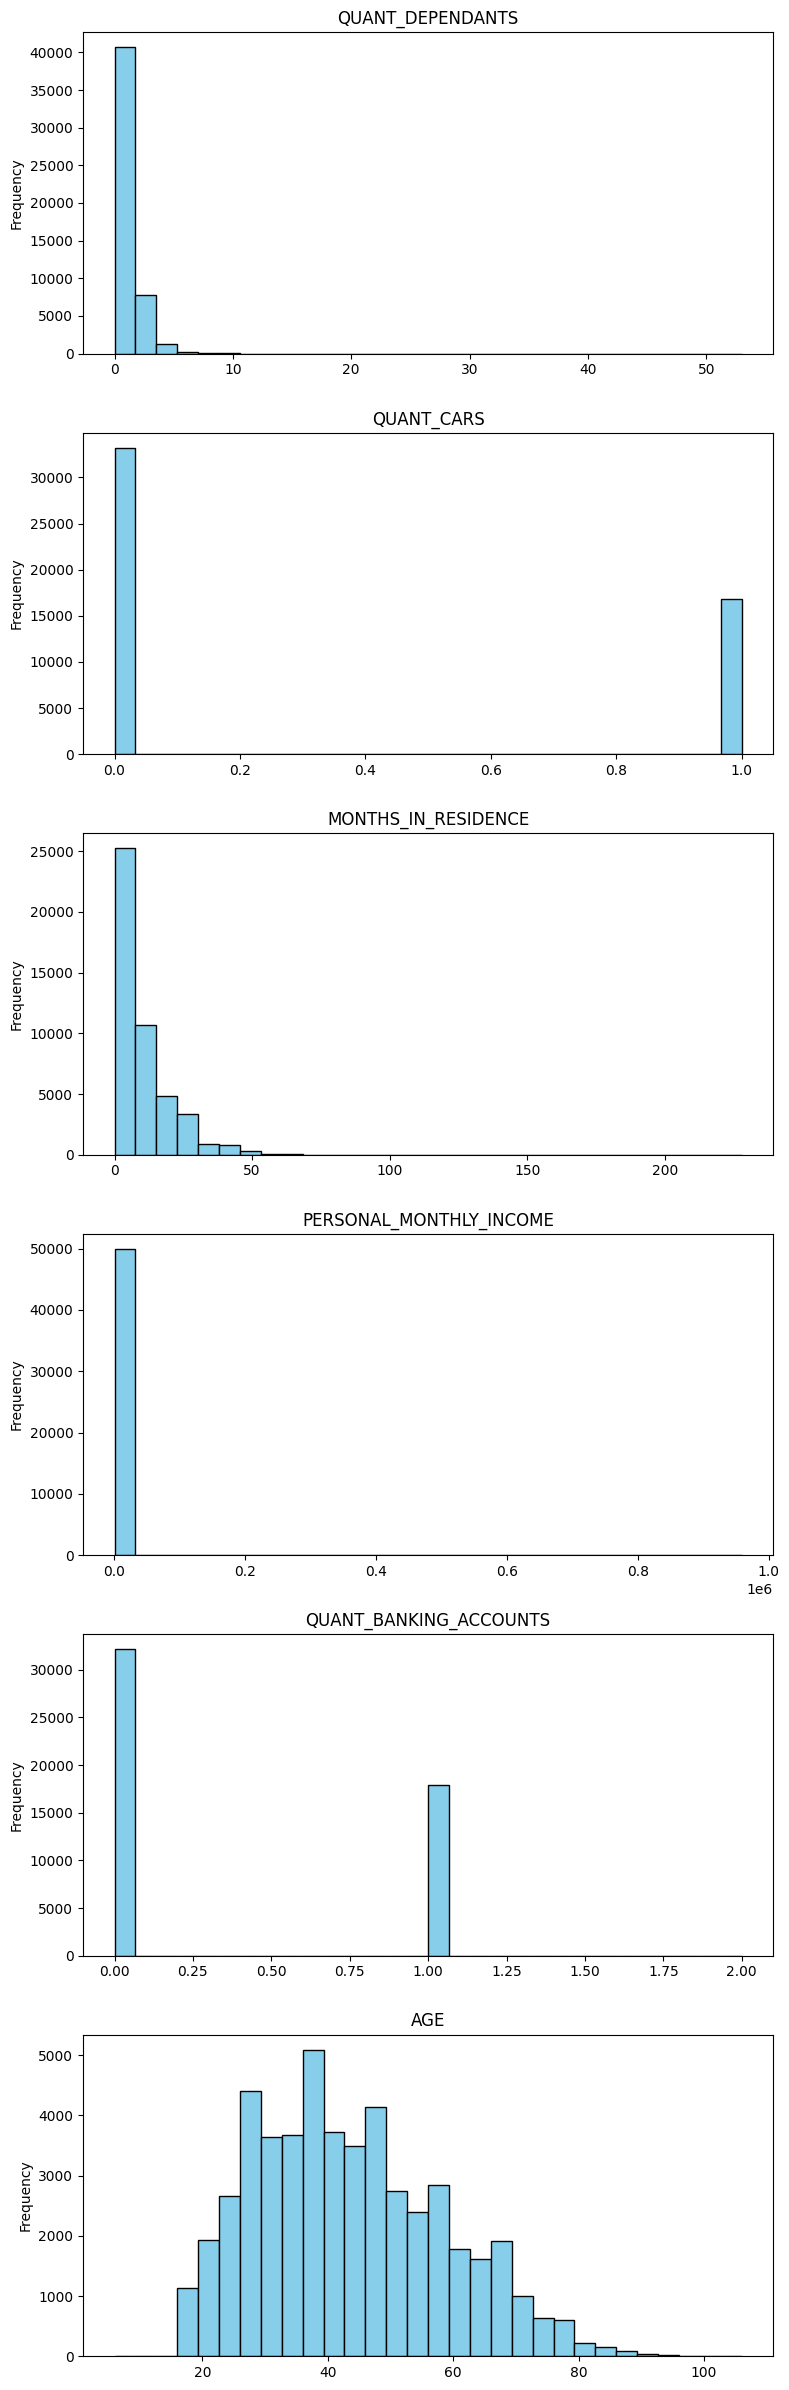

In [9]:
"""let's visualize the data"""

# CONTINUOUS VARIABLES
import matplotlib.pyplot as plt
import numpy as np 

continuous_var = [
    "QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE"]

fig, axes = plt.subplots(len(continuous_var), 1, figsize=(8, 4*len(continuous_var)))

for i, var in enumerate(continuous_var):
    axes[i].hist(df_selected[var].dropna(), bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(var)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [10]:
# Getting to know the data better
print(df_selected["QUANT_DEPENDANTS"].value_counts())

QUANT_DEPENDANTS
0     33655
1      7004
2      5363
3      2465
4       860
5       365
6       139
7        65
8        35
9        14
10       13
11        7
12        6
13        4
14        3
15        1
53        1
Name: count, dtype: int64


In [11]:
print(df_selected["QUANT_CARS"].value_counts())

QUANT_CARS
0    33193
1    16807
Name: count, dtype: int64


In [12]:
print(df_selected["QUANT_BANKING_ACCOUNTS"].value_counts())

QUANT_BANKING_ACCOUNTS
0    32122
1    17864
2       14
Name: count, dtype: int64


In [13]:
print(df_selected["SEX"].value_counts())

SEX
F    30805
M    19130
N       48
        17
Name: count, dtype: int64


In [14]:
print(df_selected["MARITAL_STATUS"].value_counts())

MARITAL_STATUS
2    25967
1    15286
4     4206
6     1877
5     1296
3      632
7      534
0      202
Name: count, dtype: int64


In [15]:
print(df_selected["OCCUPATION_TYPE"].value_counts())

OCCUPATION_TYPE
2.0    16947
1.0     8742
4.0     7000
5.0     6891
0.0     2788
3.0      319
Name: count, dtype: int64


In [16]:
print(df_selected["RESIDENCE_TYPE"].value_counts())

RESIDENCE_TYPE
1.0    41572
2.0     3884
5.0     1983
0.0      760
4.0      311
3.0      141
Name: count, dtype: int64


In [17]:
print(df_selected["RESIDENCIAL_STATE"].value_counts())

RESIDENCIAL_STATE
SP    8773
RS    5261
BA    4991
CE    4619
PE    3670
MG    3085
PA    2247
RJ    2143
RN    2027
GO    1694
PR    1523
AL    1467
PB    1361
MT    1301
MA     761
DF     700
MS     698
ES     688
SC     668
AP     493
AM     402
PI     374
RO     363
SE     273
AC     227
TO     130
RR      61
Name: count, dtype: int64


In [18]:
print(df_selected["RESIDENCIAL_CITY"].value_counts())

RESIDENCIAL_CITY
Sao Paulo               894
FORTALEZA               876
Fortaleza               714
MACEIO                  651
PELOTAS                 624
                       ... 
MEDEIROS N ETO            1
PARECI NOVO               1
CAPIM GROSSO              1
pauloa fonso              1
conselheiro lafaiete      1
Name: count, Length: 3529, dtype: int64


In [19]:
print(df_selected["RESIDENCIAL_BOROUGH"].value_counts())

RESIDENCIAL_BOROUGH
CENTRO                                   4169
Centro                                    425
ZONA RURAL                                372
centro                                    347
Fragata                                   237
                                         ... 
RUROPOLIS CAMELA                            1
MATIEL                                      1
NOVA CANAA                                  1
Jardim San Rerssore (Caucaia do alto)       1
jardim vida nova                            1
Name: count, Length: 14511, dtype: int64


In [20]:
print(df_selected["RESIDENCIAL_ZIP_3"].value_counts())

RESIDENCIAL_ZIP_3
960    721
591    547
570    508
628    459
456    444
      ... 
470      1
430      1
675      1
991      1
802      1
Name: count, Length: 1481, dtype: int64


In [21]:
"""BELOW IS THE SET OF CODES FOR TRANSFORMATION PURPOSES"""

def categorize_dependents(x):
    if x == 0:
        return "0 dependents"
    elif 1 <= x <= 2:
        return "1 to 2 dependents"
    elif 3 <= x <= 4:
        return "3 to 4 dependents"
    else:
        return "More than 4 dependents"
    
# applying the function
df_selected['UPD_QUANT_DEPENDANTS'] = df_selected['QUANT_DEPENDANTS'].apply(categorize_dependents)
df_selected

print(df_selected['UPD_QUANT_DEPENDANTS'].value_counts())

UPD_QUANT_DEPENDANTS
0 dependents              33655
1 to 2 dependents         12367
3 to 4 dependents          3325
More than 4 dependents      653
Name: count, dtype: int64


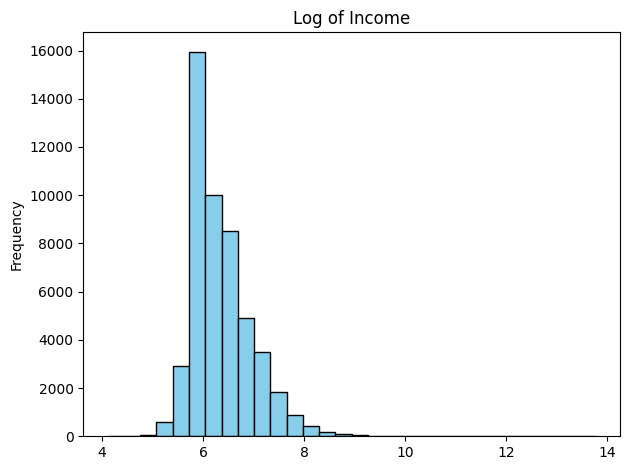

In [23]:
df_selected['LOG_PERSONAL_MONTHLY_INCOME'] = np.log(df_selected['PERSONAL_MONTHLY_INCOME'] + 1)

fig, ax = plt.subplots()
ax.hist(df_selected['LOG_PERSONAL_MONTHLY_INCOME'], bins=30, color='skyblue', edgecolor='black')
ax.set_title('Log of Income')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [24]:
valid_sex_categories = ['F', 'M']
df_selected['SEX'] = df_selected['SEX'].apply(lambda x: x if x in valid_sex_categories else np.nan)

print(df_selected['SEX'].value_counts())

SEX
F    30805
M    19130
Name: count, dtype: int64


In [25]:
print(df_selected.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   QUANT_DEPENDANTS             50000 non-null  int64  
 1   QUANT_CARS                   50000 non-null  int64  
 2   MONTHS_IN_RESIDENCE          46223 non-null  float64
 3   PERSONAL_MONTHLY_INCOME      50000 non-null  float64
 4   QUANT_BANKING_ACCOUNTS       50000 non-null  int64  
 5   AGE                          50000 non-null  int64  
 6   SEX                          49935 non-null  object 
 7   MARITAL_STATUS               50000 non-null  int64  
 8   OCCUPATION_TYPE              42687 non-null  float64
 9   RESIDENCE_TYPE               48651 non-null  float64
 10  RESIDENCIAL_STATE            50000 non-null  object 
 11  RESIDENCIAL_CITY             50000 non-null  object 
 12  RESIDENCIAL_BOROUGH          50000 non-null  object 
 13  RESIDENCIAL_ZIP_

### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

**RESPONSE**

The problem with the RESIDENCIAL_CITY and RESIDENCIAL_BOROUGH variables, as indicated by the value counts, seems to be data inconsistency due to typos and different capitalizations. For example, "FORTALEZA" and "Fortaleza" are the same city but are represented differently in the dataset. This leads to a fragmentation of the data, where the same entity is counted separately due to text format differences. Moreover, "borough" typically refers to a subdivision of a city, a more localized area, while "city" refers to the broader municipality. The distinction between a borough and a city can be quite important, especially in geospatial analysis or when assessing locality-specific trends.

In [26]:
# Dropping three string RESIDENCIAL_ variables

df_dropped = df_selected.drop(['RESIDENCIAL_STATE', 'RESIDENCIAL_CITY', 'RESIDENCIAL_BOROUGH', 'QUANT_DEPENDANTS'], axis=1)
df_dropped

,QUANT_CARS,MONTHS_IN_RESIDENCE,PERSONAL_MONTHLY_INCOME,QUANT_BANKING_ACCOUNTS,AGE,SEX,MARITAL_STATUS,OCCUPATION_TYPE,RESIDENCE_TYPE,RESIDENCIAL_ZIP_3,TARGET_LABEL_BAD=1,UPD_QUANT_DEPENDANTS,LOG_PERSONAL_MONTHLY_INCOME
0,0,15.0,900.00,0,32,F,6,4.0,1.0,595,1,1 to 2 dependents,6.803505
1,0,1.0,750.00,0,34,F,2,4.0,1.0,230,1,0 dependents,6.621406
2,0,NaN,500.00,0,27,F,2,NaN,1.0,591,0,0 dependents,6.216606
3,0,NaN,500.00,0,61,F,2,NaN,NaN,545,0,0 dependents,6.216606
4,0,12.0,1200.00,0,48,M,2,5.0,1.0,235,1,0 dependents,7.090910
...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,14.0,1451.00,1,36,F,1,4.0,1.0,591,1,1 to 2 dependents,7.280697
49996,0,15.0,450.00,0,21,F,1,NaN,1.0,186,0,0 dependents,6.111467
49997,0,5.0,1555.00,0,41,M,2,2.0,2.0,715,0,3 to 4 dependents,7.349874
49998,0,NaN,1443.27,0,28,F,1,2.0,1.0,320,1,1 to 2 dependents,7.275359


## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false omission rate of 19%, how many true negatives will they be able to enroll?

## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

### Exercise 10

How does the partial correlation with respect to age look?

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false omission rate of 19%?

### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

### Exercise 14

How many true negatives can you get now at a less than 19% False Omission Rate?

### Exercise 15

Add an interaction term between age and personal income.

### Exercise 16

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

### Exercise 17

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:


```python
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)
```